In [ ]:
import pandas as pd
import numpy as np

import json

import matplotlib as plt
import seaborn as sns
import os
import gc
import random 

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

### Helper Functions

In [ ]:
def predict_top_speaker(texts, model, tokenizer, top_k=3):
    import torch
    model.eval()
    expected_keys = ['input_ids', 'attention_mask', 'token_type_ids']
    preds = []

    for i, text in enumerate(texts):
        try:
            inputs = tokenizer(
                [text],
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=1044
            )
            model_inputs = {k: v.to(model.device) for k, v in inputs.items() if k in expected_keys}

            with torch.no_grad():
                outputs = model(**model_inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze()

                # Get top-k indices & values
                top_probs, top_indices = torch.topk(probs, k=top_k)

                # Build dictionary for top speakers
                pred_dict = {}
                for rank, (idx, p) in enumerate(zip(top_indices.tolist(), top_probs.tolist()), start=1):
                    pred_dict[f"speaker_{rank}_id"] = idx
                    pred_dict[f"speaker_{rank}_name"] = ID2SPEAKER.get(idx, "unknown")
                    pred_dict[f"speaker_{rank}_prob"] = p

                # Also include full probability distribution if needed
                pred_dict["probs"] = probs.tolist()

                preds.append(pred_dict)

        except Exception as e:
            print(f"[!] Failed on row {i}: {e}")
            preds.append({
                "speaker_1_id": -1,
                "speaker_1_name": "No Speaker",
                "speaker_1_prob": 0.0,
                "speaker_2_id": -1,
                "speaker_2_name": "No Speaker",
                "speaker_2_prob": 0.0,
                "speaker_3_id": -1,
                "speaker_3_name": "No Speaker",
                "speaker_3_prob": 0.0,
                "probs": [0 for _ in range(len(TARGETS))]
            })

    return preds


def clean_responses(text):
    # Remove anything in [brackets]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove words or tokens ending with ':' (like JoeSmith:)
    text = re.sub(r'\b\w+:\s*', '', text)

    # remove assistant
    text = re.split(r'assistant', text, flags=re.IGNORECASE)[0]

    # Strip extra whitespace
    text = text.strip()
    
    return text

def get_results(df, model, tokenizer):
    responses = df['model_response'].values
    responses = [clean_responses(x) for x in responses]

    predictions = predict_top_speaker(responses, model, tokenizer)
    df['speaker_1']= [x['speaker_1_name'] for x in predictions]
    df['speaker_2']= [x['speaker_2_name'] for x in predictions]
    df['speaker_3']= [x['speaker_3_name'] for x in predictions]

    return df

### Load Data

In [ ]:
datasets = ['Albermale', 'DCAppeals', 'Waipa']
models = ['llama', 'qwen', 'gpt']
SYSTEM_MESSAGES=["none", "full", "no_micro", "no_examples", "no_profile", "no_context"]
data_types = ['min_token', 'tags']


albermale = [
    'ellenosborne','davidoberg','grahampaige','jonnoalcaro',
    'katrinacallsen','kateacuff','judyle'
]

dcappeals = ['judgemcleese', 'judgeglickman', 'judgedeahl', 'judgeeasterly', 'judgeblackburn', 'judgethompson']

waipa = ["susanoregan", "jimmylchreest", "clairestpierre", "andrewbrown", "rogergordon","loubrown", "angeholt", "suemilner"]


In [ ]:
results_df = pd.DataFrame([])
for dataset in datasets:
    MODEL_REPO = f'smerrillunc/{dataset}_prediction'
    
    if dataset == 'Albermale':
        TARGETS = albermale
    elif dataset == 'DCAppeals':
        TARGETS = dcappeals
    elif dataset == 'Waipa':
        TARGETS = waipa
        
    SPEAKER2ID = {name: i for i, name in enumerate(TARGETS)}
    ID2SPEAKER = {i: name for name, i in SPEAKER2ID.items()}

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_REPO)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_REPO, use_fast=True)
    for model_name in models:
        for data_type in data_types:
            for system_message in SYSTEM_MESSAGES:
                if dataset == 'DCAppeals':
                    if system_message in ["none", "full"]:
                        if data_type in ['min_token']:
                            continue
                print(f'Processing {dataset}, {model_name}, {data_type}, {system_message}')
                dir_path = path.format(dataset, data_type, model_name, system_message)
                files = os.listdir(dir_path)
                for file in files:
                    print(file)
                    try:
                        df = pd.read_csv(os.path.join(dir_path, file))
                    except:
                        continue
                    if 'baseline'in file:
                        for speaker in df['dataset'].unique():
                            baseline = df[df['dataset']==speaker]    
                            tmp = get_results(baseline, model, tokenizer)
                            tmp['dataset'] = dataset
                            tmp['model_name'] = model_name
                            tmp['data_type'] = data_type
                            tmp['system_message'] = system_message
                            tmp['baseline'] = True
                            tmp['agent'] = speaker
                            results_df = pd.concat([results_df, tmp])
                        
                    else:
                        speaker = file.split('.')[0]
                        tmp = get_results(df, model, tokenizer)
                        tmp['dataset'] = dataset
                        tmp['model_name'] = model_name
                        tmp['data_type'] = data_type
                        tmp['system_message'] = system_message
                        tmp['baseline'] = False
                        tmp['agent'] = speaker
                        results_df = pd.concat([results_df, tmp])
                    

### Analysis

In [ ]:
results_df['top_1'] = (results_df['speaker_1'] == results_df['agent'])
results_df['top_2'] = (results_df['speaker_2'] == results_df['agent']) |  (results_df['top_1']==True)
results_df['top_3'] = (results_df['speaker_3'] == results_df['agent']) | (results_df['top_2']==True)

In [ ]:
group_cols = ['dataset', 'model_name', 'data_type', 'system_message', 'baseline']
# Compute mean and std

agg_df = (
    results_df.groupby(group_cols)['top_1']
      .agg(
          mean='mean',
          std='std',
          stderr=lambda x: x.std(ddof=1) / np.sqrt(len(x))
      )
      .reset_index()
)

display(agg_df)

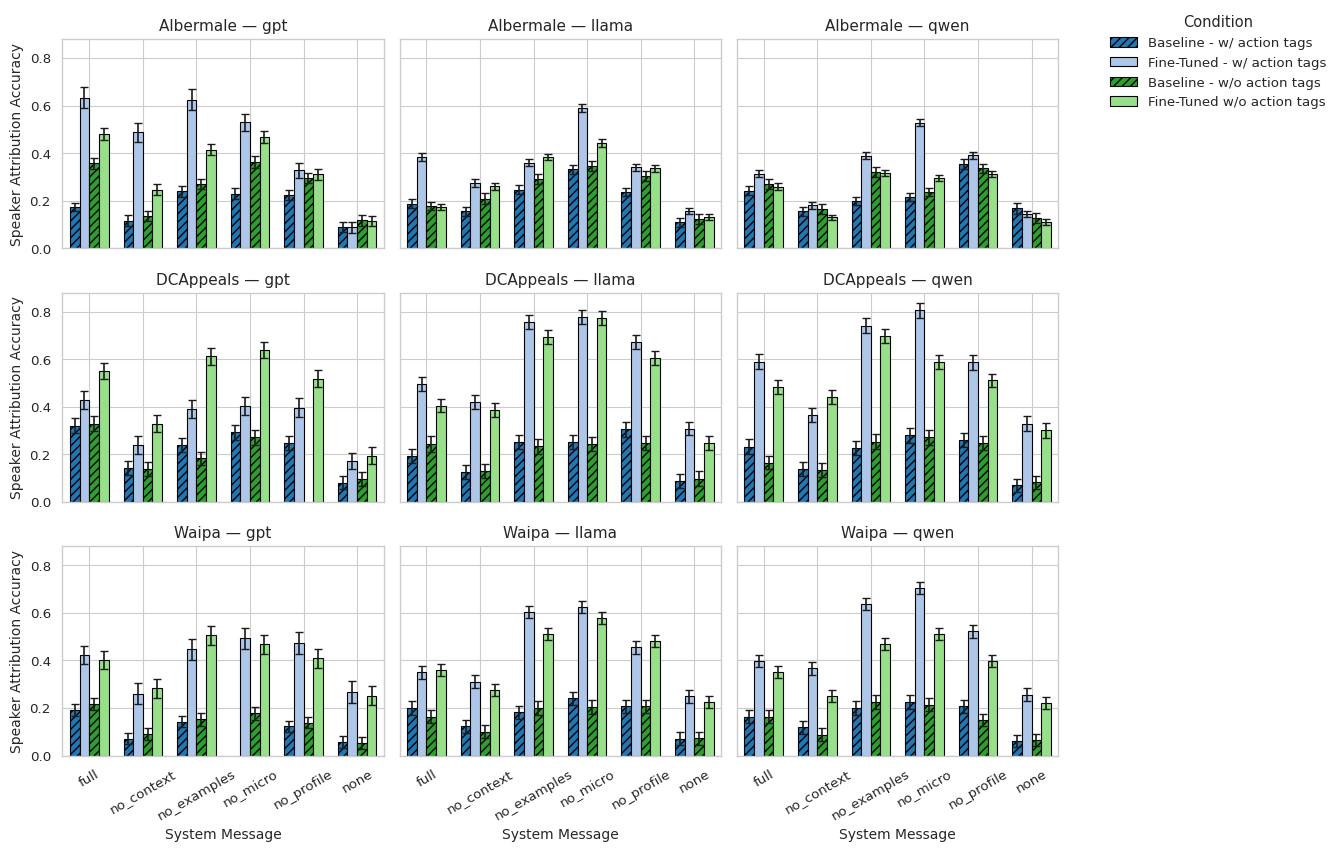

In [123]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)

# ------------------- CONFIG -------------------
system_order = ['full', 'no_context', 'no_examples', 'no_micro', 'no_profile', 'none']
datasets = sorted(agg_df['dataset'].unique())
models = sorted(agg_df['model_name'].unique())
bar_width = 0.18
cond_order = ['baseline-tags', 'our-tags', 'baseline-min_token', 'our-min_token']

# Colorblind-safe colors
palette = {
    'baseline-tags': '#1f77b4',      # medium blue
    'our-tags': '#aec7e8',           # light blue
    'baseline-min_token': '#2ca02c', # medium green
    'our-min_token': '#98df8a'       # light green
}

# Hatch patterns for baseline vs fine-tuned
hatch_patterns = {
    'baseline-tags': '////',
    'our-tags': '',
    'baseline-min_token': '////',
    'our-min_token': ''
}

# Legend labels
legend_labels = {
    'baseline-tags': 'Baseline - w/ action tags',
    'our-tags': 'Fine-Tuned - w/ action tags',
    'baseline-min_token': 'Baseline - w/o action tags',
    'our-min_token': 'Fine-Tuned w/o action tags'
}
# ------------------------------------------------

# Prepare figure
nrows = len(datasets)
ncols = len(models)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharey=True, sharex=True)
if nrows == 1: axes = np.expand_dims(axes, 0)
if ncols == 1: axes = np.expand_dims(axes, 1)

# Plot bars with stderr
for i, ds in enumerate(datasets):
    for j, model in enumerate(models):
        ax = axes[i, j]
        sub = agg_df[(agg_df.dataset==ds) & (agg_df.model_name==model)].copy()
        if sub.empty:
            ax.set_visible(False)
            continue

        sub['system_message'] = pd.Categorical(sub['system_message'], categories=system_order, ordered=True)
        sub['cond'] = sub.apply(lambda r: f"{'baseline' if r.baseline else 'our'}-{r.data_type}", axis=1)

        x_coords = np.arange(len(system_order))
        for k, cond in enumerate(cond_order):
            cond_sub = sub[sub['cond']==cond]
            heights = []
            errors = []  # collect stderr values
            for sm in system_order:
                row = cond_sub[cond_sub['system_message']==sm]
                if len(row)==0:
                    heights.append(np.nan)
                    errors.append(0)
                else:
                    heights.append(row['mean'].values[0])
                    errors.append(row['stderr'].values[0])  # <-- add stderr

            # Offset bars for grouping
            offset = (k - 1.5) * bar_width
            ax.bar(x_coords + offset, heights, width=bar_width,
                   color=palette[cond],
                   hatch=hatch_patterns[cond],
                   label=legend_labels[cond] if (i==0 and j==0) else "",
                   edgecolor='black', linewidth=0.8,
                   yerr=errors, capsize=3)  # <-- add error bars

        # Axes formatting
        ax.set_xticks(x_coords)
        ax.set_xticklabels(system_order, rotation=30)
        if i==nrows-1: ax.set_xlabel("System Message", fontsize=10)
        if j==0: ax.set_ylabel("Speaker Attribution Accuracy", fontsize=10)
        ax.set_title(f"{ds} — {model}", fontsize=11)
        ax.set_xlim(-0.5, len(system_order)-0.5)

# Legend
handles, _ = axes[0,0].get_legend_handles_labels()
fig.legend(handles, legend_labels.values(), title="Condition",
           bbox_to_anchor=(0.92, 0.95), loc='upper left', frameon=False)

plt.tight_layout(rect=[0,0,0.9,0.95])
plt.savefig('SAA.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [124]:
def escape_latex(text):
    return re.sub(r'_', r'\\_', str(text))

datasets = sorted(agg_df['dataset'].unique())
models = sorted(agg_df['model_name'].unique())
system_messages = ['full', 'no_context', 'no_examples', 'no_micro', 'no_profile', 'none']

def ci_val(row):
    if row.empty:
        return "-"
    return f"{row['mean'].values[0]:.2f} ± {row['stderr'].values[0]:.2f}"

print("\\begin{table*}[ht]")
print("\\centering")
print("\\caption{Speaker Attribution: Baseline vs Fine-Tuned Models on Three Datasets}")
print("\\label{tab:speaker_attribution}")

for ds in datasets:
    print(f"\\begin{{subtable}}[t]{{0.95\\textwidth}}")
    print("\\centering")
    print("\\scriptsize")
    print("\\begin{tabular}{l" + "c"*len(system_messages) + "}")
    print("\\toprule")
    header_titles = [escape_latex(s) for s in system_messages]
    print("Model & " + " & ".join(header_titles) + " \\\\")
    print("\\midrule")

    for model in models:
        # w/ action tags
        row_values = [f"\\textbf{{{escape_latex(model)} w/ action tags}}"]
        for sm in system_messages:
            baseline = agg_df[(agg_df['dataset']==ds) &
                              (agg_df['model_name']==model) &
                              (agg_df['system_message']==sm) &
                              (agg_df['baseline']==True) &
                              (agg_df['data_type']=='tags')]
            nobaseline = agg_df[(agg_df['dataset']==ds) &
                                (agg_df['model_name']==model) &
                                (agg_df['system_message']==sm) &
                                (agg_df['baseline']==False) &
                                (agg_df['data_type']=='tags')]
            row_values.append(f"{ci_val(nobaseline)} / {ci_val(baseline)}")
        print(" & ".join(row_values) + " \\\\")

        # w/o action tags
        row_values = [f"\\textbf{{{escape_latex(model)} w/o action tags}}"]
        for sm in system_messages:
            baseline = agg_df[(agg_df['dataset']==ds) &
                              (agg_df['model_name']==model) &
                              (agg_df['system_message']==sm) &
                              (agg_df['baseline']==True) &
                              (agg_df['data_type']=='min_token')]
            nobaseline = agg_df[(agg_df['dataset']==ds) &
                                (agg_df['model_name']==model) &
                                (agg_df['system_message']==sm) &
                                (agg_df['baseline']==False) &
                                (agg_df['data_type']=='min_token')]
            row_values.append(f"{ci_val(nobaseline)} / {ci_val(baseline)}")
        print(" & ".join(row_values) + " \\\\")

    print("\\bottomrule")
    print("\\end{tabular}")
    print(f"\\caption{{Speaker Attribution Accuracy for {escape_latex(ds)}.}}")
    print(f"\\label{{tab:SAA_{escape_latex(ds.lower().replace(' ', '_'))}}}")
    print("\\end{subtable}")
    print("\\vspace{0.3cm}\n")

print("\\end{table*}")


\begin{table*}[ht]
\centering
\caption{Speaker Attribution: Baseline vs Fine-Tuned Models on Three Datasets}
\label{tab:speaker_attribution}
\begin{subtable}[t]{0.95\textwidth}
\centering
\scriptsize
\begin{tabular}{lcccccc}
\toprule
Model & full & no\_context & no\_examples & no\_micro & no\_profile & none \\
\midrule
\textbf{gpt w/ action tags} & 0.63 ± 0.04 / 0.17 ± 0.02 & 0.49 ± 0.04 / 0.12 ± 0.02 & 0.62 ± 0.04 / 0.24 ± 0.02 & 0.53 ± 0.03 / 0.23 ± 0.02 & 0.33 ± 0.03 / 0.22 ± 0.02 & 0.09 ± 0.02 / 0.09 ± 0.02 \\
\textbf{gpt w/o action tags} & 0.48 ± 0.03 / 0.36 ± 0.02 & 0.25 ± 0.02 / 0.14 ± 0.02 & 0.41 ± 0.02 / 0.27 ± 0.02 & 0.47 ± 0.02 / 0.36 ± 0.02 & 0.31 ± 0.02 / 0.30 ± 0.02 & 0.12 ± 0.02 / 0.12 ± 0.02 \\
\textbf{llama w/ action tags} & 0.38 ± 0.02 / 0.19 ± 0.02 & 0.27 ± 0.02 / 0.16 ± 0.02 & 0.36 ± 0.01 / 0.25 ± 0.02 & 0.59 ± 0.02 / 0.33 ± 0.02 & 0.34 ± 0.01 / 0.24 ± 0.02 & 0.16 ± 0.01 / 0.11 ± 0.02 \\
\textbf{llama w/o action tags} & 0.17 ± 0.01 / 0.18 ± 0.02 & 0.26 ± 0.02 / 0.21